In [16]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [17]:
PATH_ROOT = os.path.join(Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [18]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [19]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_alfa_svm_db.csv'))
print(df.shape)

(1350, 38)


In [20]:
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
df['Difficulty'] = df['Difficulty'].astype(cat_type)

In [21]:
print(df.columns)

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base', 'Difficulty'],
      dtype='object')


In [22]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
COL_Y = 'Test.Poison'

print(len(df))

1350


In [8]:
N_ITER_SEARCH = 100

# Find parameter
param = {'alpha': loguniform(1e-4, 10),}
X = df[COLS_CM]
y = df[COL_Y]
regressor = linear_model.Ridge()
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(X, y)

best_estimator_ = param_search.best_estimator_.get_params()
alpha = np.round(best_estimator_['alpha'], 4)
print(alpha)

0.0151


In [9]:
N_FOLD = 5

df['Prediction'] = 0.

# Split by clean data
idx_clean = df[df['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(idx_clean):
    idx_train_clean = idx_clean[i_train]
    idx_test_clean = idx_clean[i_test]

    data_train = df.loc[idx_train_clean, 'Data.Base']
    data_test = df.loc[idx_test_clean, 'Data.Base']

    idx_train = df[df['Data.Base'].isin(data_train)].index
    idx_test = df[df['Data.Base'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

    X_train = df.loc[idx_train, COLS_CM]
    y_train = df.loc[idx_train, COL_Y]
    X_test = df.loc[idx_test, COLS_CM]
    y_test = df.loc[idx_test, COL_Y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

# Apply clipping
df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

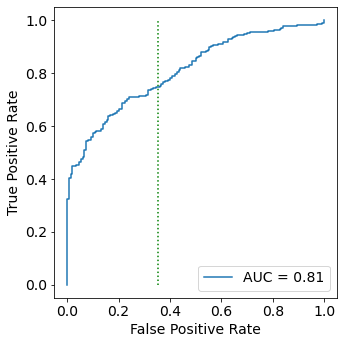

0.3523356738353295


In [10]:
THRESHOLD = 0.0

FONTSIZE = 14
FIGSIZE = (5, 5)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
y_true_ = (df['Rate'] > THRESHOLD).astype(int)
y_score_ = df['Train.Poison'] - df['Prediction']
fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
roc_auc_ = auc(fpr, tpr)
idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
threshold = thresholds[idx_t]
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_).plot(ax=ax)
ax.vlines(threshold, 0, 1, linestyles='dotted', label='threshold', colors='green')
plt.tight_layout()
plt.show()

print(threshold)

In [11]:
for dif in DIF_LEVELS:
    n = df[df['Difficulty'] == dif].shape[0]
    print(f'{dif}: {n}')

Hard: 450
Normal: 450
Easy: 450


In [12]:
df_ = df[(df['Difficulty'] == 'Normal') & (df['Rate'] == 0)]
# df_ = df[df['Rate'] == 0]
dif_00 = (df_['Train.Poison'] - df_['Prediction'])
print(dif_00.min(), dif_00.max())

threshold = np.quantile(dif_00, 0.95)
print(threshold)

0.016659496472196444 0.31498830933456534
0.2954427890700791


In [13]:
print('C-Measure threshold:', threshold)

C-Measure threshold: 0.2954427890700791


In [14]:
results = (df['Train.Poison'] - df['Prediction']) > threshold
df_ = df[['Difficulty', 'Rate']].copy()
df_['Prediction'] = results.astype(int)
df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
df_grouped = df_grouped.reset_index()
df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
df_pivot

Dataset Difficulty,Easy,Normal,Hard
Poisoning Rate,,,
0.00,0,3,21
0.05,0,6,27
0.10,0,23,40
0.15,3,33,43
0.20,17,36,43
0.25,25,39,47
0.30,31,40,45
0.35,37,43,45
0.40,39,42,47


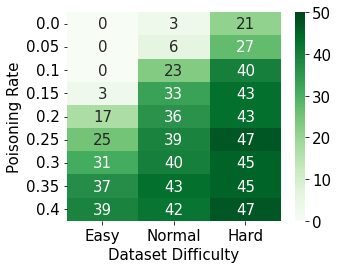

In [24]:
FONTSIZE = 15
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(df_pivot, ax=ax, annot=True, fmt='d', cmap="Greens", vmin=0, vmax=50)
plt.yticks(rotation=0)
plt.tight_layout()
plot_output = os.path.join(path_output, 'synth_heatmap.pdf')
plt.savefig(plot_output, dpi=300)